In [1]:
import copy 
import time
import pickle 
import warnings
import scipy
import scipy.sparse.linalg
from collections import defaultdict, OrderedDict

from numpy import matrix, asmatrix
from scipy.sparse.sputils import asmatrix

import random
import numpy as np
import fastmat as fm  # need 0.2a3 or later?

import matplotlib.gridspec as gridspec
warnings.filterwarnings("ignore")
from pylab import rcParams
from matplotlib import container
from matplotlib import pyplot as plt
from IPython.core.display import  HTML
from matplotlib import cm # Colormaps

import os, sys
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
os.environ['PRJ'] = "~/skisg/"
sys.path.append(os.environ['PRJ'])

random.seed(1337)
np.random.seed(1337)

%load_ext autoreload
%autoreload 2

/var/folders/gj/ns_zjdqx57b1mrqf3l8_rcd40000gp/T/ipykernel_98291/1148733654.py:10: DeprecationWarning: Please use `asmatrix` from the `scipy.sparse` namespace, the `scipy.sparse.sputils` namespace is deprecated.
  from scipy.sparse.sputils import asmatrix


In [2]:
from skisg.config import SgBasisType, InterpType
from skisg.interp.sparse.basis import phi, phi_li, phi_li_nd

from skisg.interp.sparse.sgindices import compute_indices, compute_levels, get_multi_index_sequence, lexorder_matrix
from skisg.interp.sparse.sgindices import get_level_indices, help_level_indices, compute_LI_1d, compute_LI

from skisg.interp.sparse.sglocations import get_sg_points_1d, get_sg_points_nd
from skisg.interp.sparse.basis import get_sparse_basis_1d 
from skisg.interp.sparse.basis import get_sg_subgrid_basis #as get_sg_basis

from skisg.interp.sparse.weights import compute_B, compute_phi_1d

from skisg.interp.sparse.construct import get_subgrids

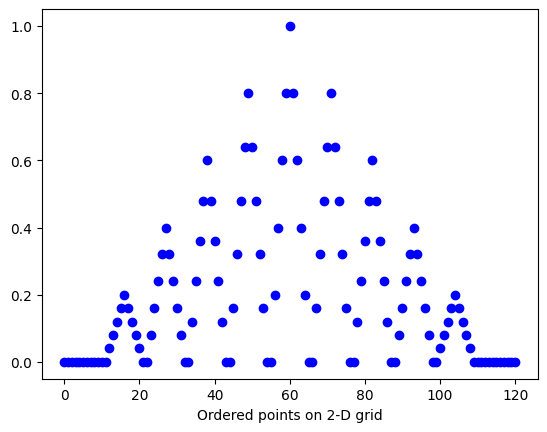

In [3]:
## Testing grid coefficient computation for n-D 

## Base case: m = 0  

ndimpoints = 11
epsilon = 10**(-7)
x1s = np.linspace(0 + epsilon, 1 - epsilon, num=ndimpoints)
x2s = np.linspace(0 + epsilon, 1 - epsilon, num=ndimpoints)
x1, x2 = np.meshgrid(x1s, x2s) # Generate grid
X = np.vstack([x1.ravel(), x2.ravel()]).T
npoints = X.shape[0]

plt.plot(get_sg_subgrid_basis(X, [(0, 1, 1), (0, 1, 1)]).toarray(), "+")
plt.plot(phi_li_nd(X, [0, 0], [1,1]), "ob")

plt.xlabel("Ordered points on 2-D grid")
plt.show()
assert np.sum(get_sg_subgrid_basis(X, [(0, 1, 1), (0, 1, 1)]).toarray().squeeze(-1) - phi_li_nd(X, [0, 0], [1,1])) == 0 


## Comparing \Phi coefficients and basis functions for 2-D for grid 

ndim = 2 

grid_levels = [2, 3, 1]

for grid_level in grid_levels[::-1]:
    LI = compute_LI(grid_level, ndim)
    order = compute_LI(grid_level, ndim, rmat=False)
    L, I = LI[:, ::2], LI[:, 1::2]
    subgrids = get_subgrids(grid_level, ndim, umin=0, umax=1)
    phi_x_c = np.hstack([get_sg_subgrid_basis(X, subgrid, grid_in_level=True).toarray().reshape(npoints, -1) for subgrid in subgrids])
    phi_x_c = phi_x_c[:, order]
    phi_x_d = np.vstack([phi_li_nd(X, l, i) for l, i in zip(L, I)]).T
    assert np.sum(phi_x_d - phi_x_c) == 0 

In [4]:
## Comparing \Phi coefficients and basis functions for 3-D for grid 

ndimpoints = 11
epsilon = 10**(-7)
x1s = np.linspace(0 + epsilon, 1 - epsilon, num=ndimpoints)
x2s = np.linspace(0 + epsilon, 1 - epsilon, num=ndimpoints)
x3s = np.linspace(0 + epsilon, 1 - epsilon, num=ndimpoints)
x1, x2, x3 = np.meshgrid(x1s, x2s,x3s) # Generate grid
X = np.vstack([x1.ravel(), x2.ravel(), x3.ravel()]).T
npoints = X.shape[0]

ndim = 3
grid_levels = [0, 1, 2, 3]

for grid_level in grid_levels:
    LI = compute_LI(grid_level, ndim)
    order = compute_LI(grid_level, ndim, rmat=False)
    L, I = LI[:, ::2], LI[:, 1::2]
    subgrids = get_subgrids(grid_level, ndim, umin=0, umax=1)            
    phi_x_c = np.hstack([get_sg_subgrid_basis(X, subgrid, grid_in_level=True).toarray().reshape(npoints, -1) for subgrid in subgrids])
    phi_x_c = phi_x_c[:, order]
    phi_x_d = np.vstack([phi_li_nd(X, l, i) for l, i in zip(L, I)]).T
    assert np.sum(phi_x_d - phi_x_c) == 0 

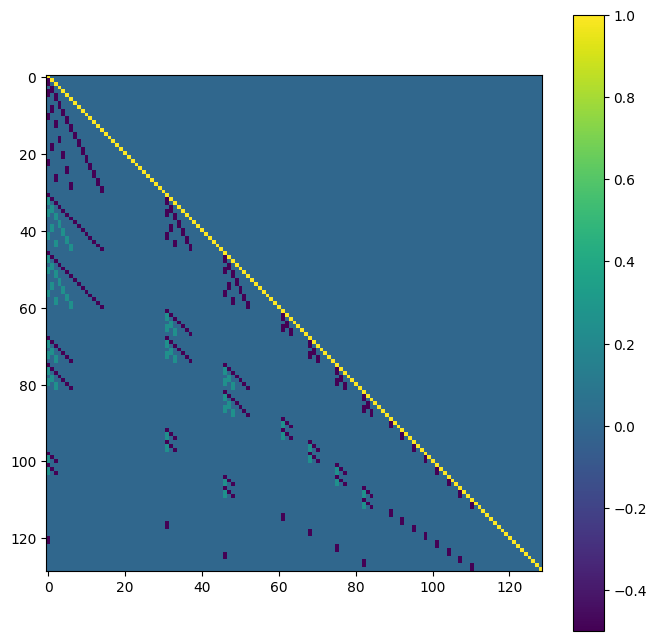

In [5]:
## Computing B matrix 
B = compute_B(4, 2, sparse=False)
plt.figure(figsize=(8, 8))
ax = plt.imshow(B.todense())
plt.colorbar(ax)
plt.show()

In [6]:

# Computing Phi
def interpolate_nd(func, f_sg,  X, gl, ndim, umin, umax):

    subgrids = get_subgrids(gl, ndim, umin=umin, umax=umax)
    order = compute_LI(gl, ndim, rmat=False)

    coeffs = [get_sg_subgrid_basis(X, subgrid, grid_in_level=True).toarray().reshape(X.shape[0], -1) for subgrid in subgrids]
    coeffs = np.hstack(coeffs)[:, order]

    # Computing B
    B = compute_B(gl, ndim, sparse=False)    
    
    # Visualizing interpolated function 
    f_h = np.matmul(coeffs@B, f_sg.reshape(-1, 1)).reshape(-1)
    
    return f_h 

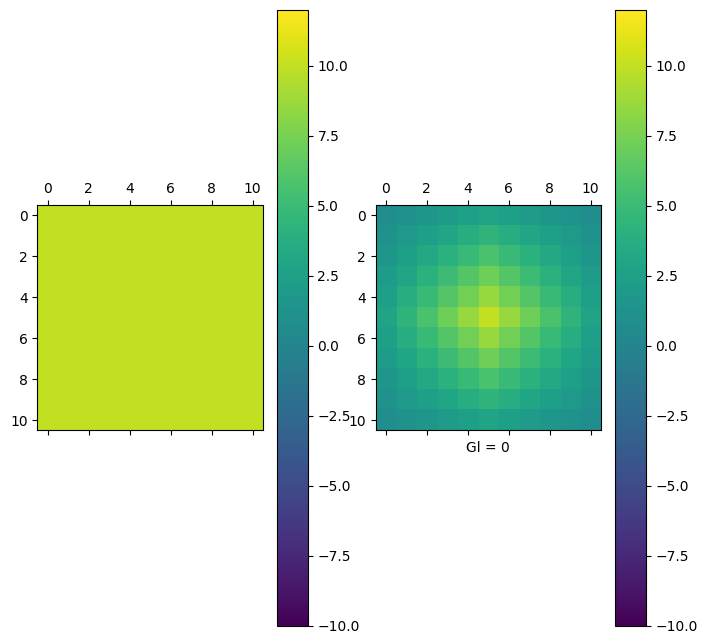

GL 0 MSE: 6.2742442840276


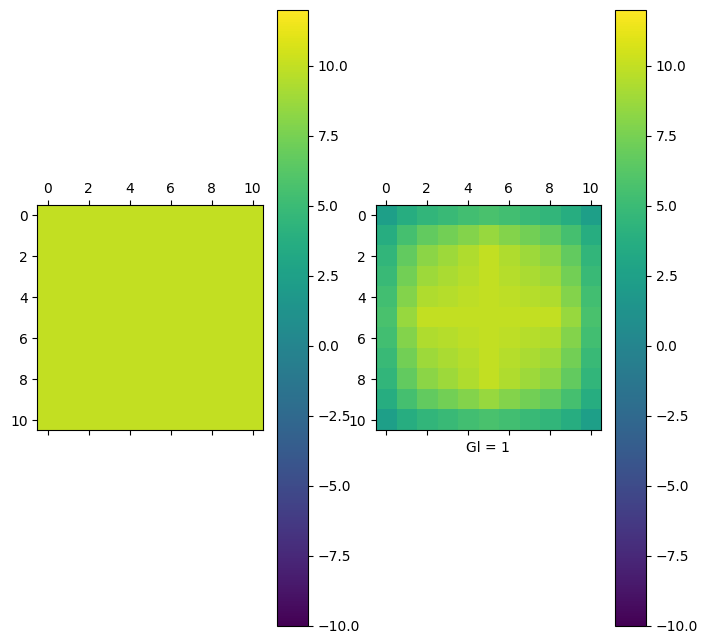

GL 1 MSE: 2.78630301770948


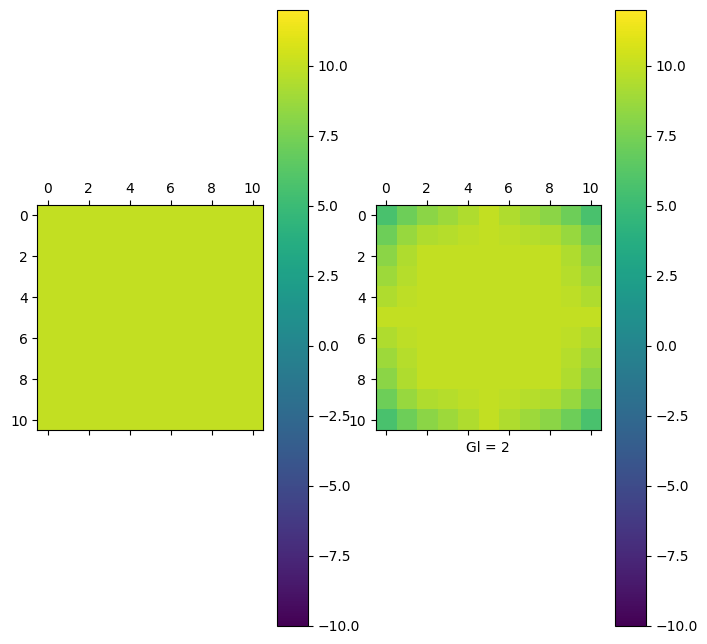

GL 2 MSE: 0.701635330072584


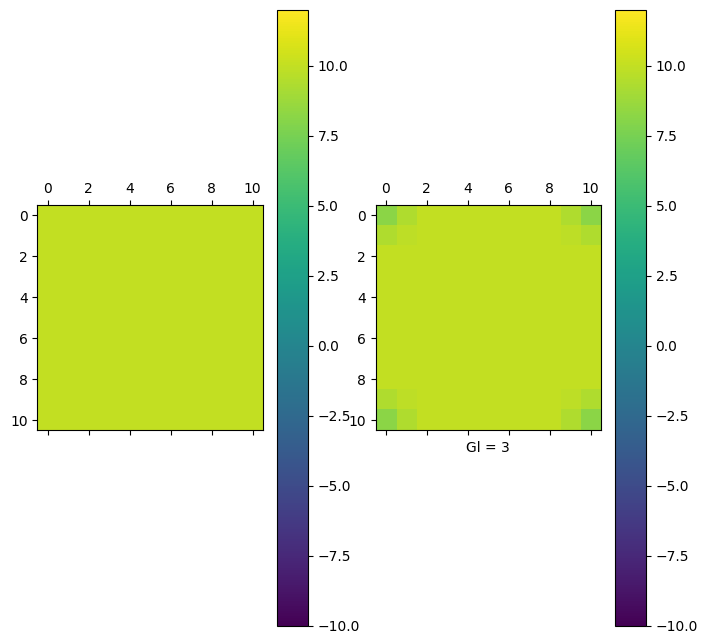

GL 3 MSE: 0.1079438097487812


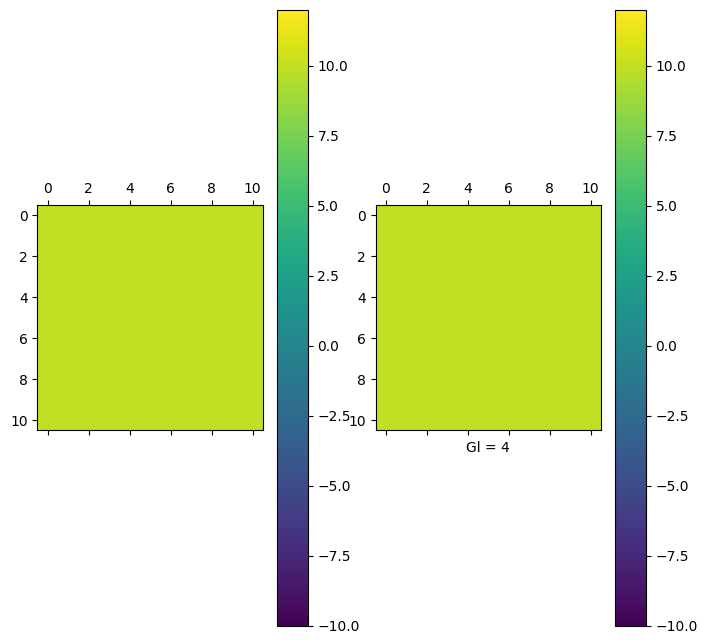

GL 4 MSE: 1.0570057226183309e-15


In [7]:
## Testing interpolation for 2-D constant function 
ndim = 2
npoints = 160 + 1
func = lambda x: 10 * np.ones(x.shape[0])

ndimpoints = 11
epsilon = 10**(-7)
x1s = np.linspace(0 + epsilon, 1 - epsilon, num=ndimpoints)
x2s = np.linspace(0 + epsilon, 1 - epsilon, num=ndimpoints)
x1, x2 = np.meshgrid(x1s, x2s) # Generate grid
X = np.vstack([x1.ravel(), x2.ravel()]).T
npoints = X.shape[0]


for gl in range(0, 5):

    order = compute_LI(gl, ndim, rmat=False)
    sg_locs = get_sg_points_nd(gl, ndim, umin=-0.2, umax=1.2, ordered=False)
    sg_locs = sg_locs[order, :]
    f_sg = func(sg_locs)
    f_h = interpolate_nd(func, f_sg, X, gl, ndim, -0.2, 1.2)

    figsize=(8, 8)
    vmin=-10
    vmax=12
    fig, axs = plt.subplots(1, 2, figsize=figsize)    
    aax = axs[0].matshow(func(X).reshape(ndimpoints, ndimpoints),vmin=-10, vmax=12)
    fig.colorbar(aax, ax=axs[0])
    aax = axs[1].matshow(f_h.reshape(ndimpoints, ndimpoints), vmin=-10, vmax=12)
    fig.colorbar(aax, ax=axs[1])
    plt.xlabel('Gl = ' + str(gl))
    plt.show()
    print("GL", gl, "MSE:", np.mean(np.abs(func(X) - f_h)))
    

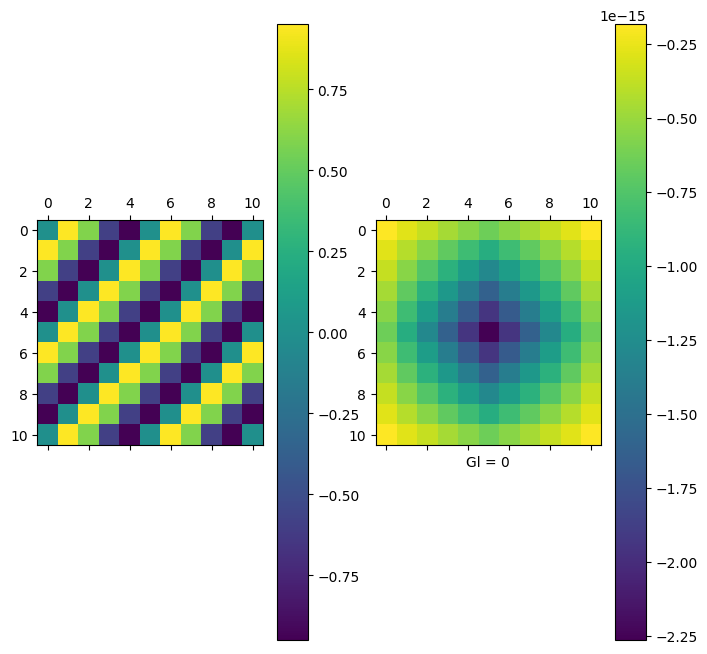

GL 0 MAE: 0.6104497943554834


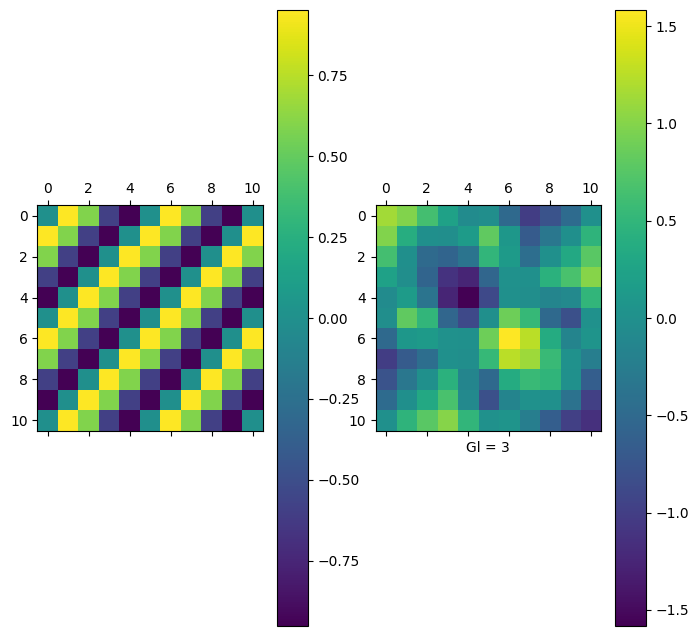

GL 3 MAE: 0.5658786546800143


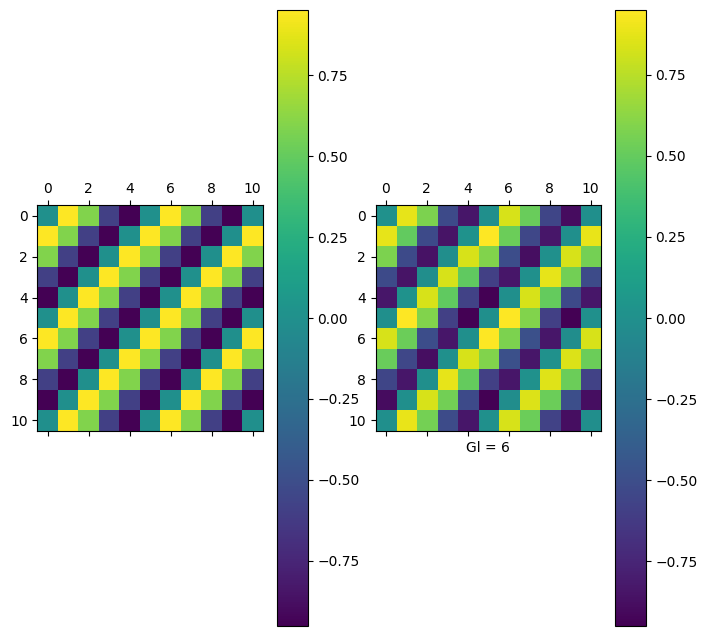

GL 6 MAE: 0.054188292246507605


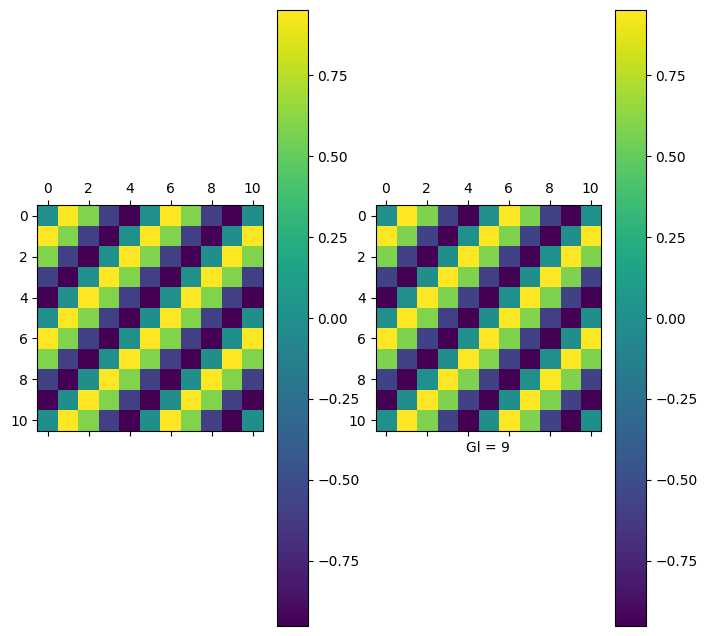

GL 9 MAE: 0.0017793191186994508


In [8]:
## Testing interpolation for 2-D sine function 

ndim = 2
npoints = 160 + 1
func = lambda x:  np.sin(4*np.pi*(x[:, 0] + x[:, 1]))

ndimpoints = 11
epsilon = 10**(-7)
x1s = np.linspace(0 + epsilon, 1 - epsilon, num=ndimpoints)
x2s = np.linspace(0 + epsilon, 1 - epsilon, num=ndimpoints)
x1, x2 = np.meshgrid(x1s, x2s) # Generate grid
X = np.vstack([x1.ravel(), x2.ravel()]).T
npoints = X.shape[0]


for gl in range(0,10,3):
    
    order = compute_LI(gl, ndim, rmat=False)
    sg_locs = get_sg_points_nd(gl, ndim, umin=-0.2, basis=SgBasisType.NAIVE, umax=1.2, ordered=False)
    sg_locs = sg_locs[order, :]
    
    f_sg = func(sg_locs)
    f_h = interpolate_nd(func, f_sg, X, gl, ndim, -0.2, 1.2)

    figsize=(8, 8)
    vmin=-10
    vmax=12
    fig, axs = plt.subplots(1, 2, figsize=figsize)    
    aax = axs[0].matshow(func(X).reshape(ndimpoints, ndimpoints)) #,vmin=-1, vmax=1)
    fig.colorbar(aax, ax=axs[0])
    aax = axs[1].matshow(f_h.reshape(ndimpoints, ndimpoints)) #, vmin=-1, vmax=1)
    fig.colorbar(aax, ax=axs[1])
    plt.xlabel('Gl = ' + str(gl))
    plt.show()
    print("GL", gl, "MAE:", np.mean(np.abs(func(X) - f_h)))

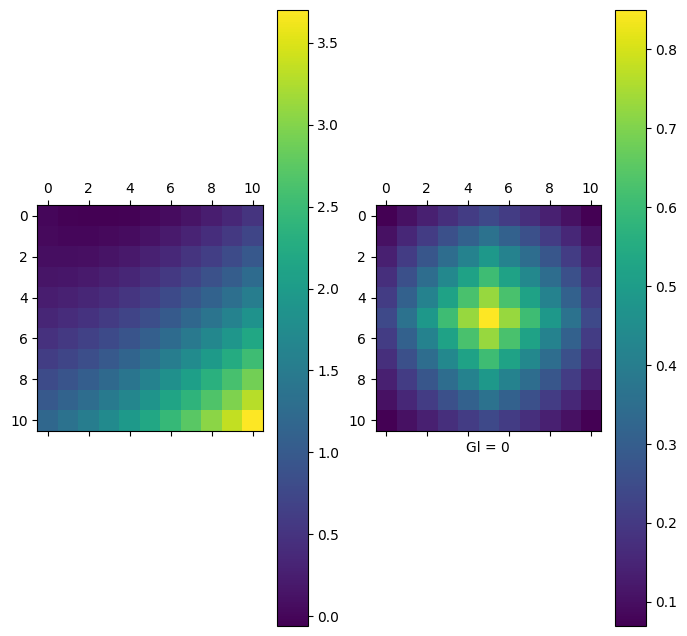

GL 0 MSE: 0.8119074176002687


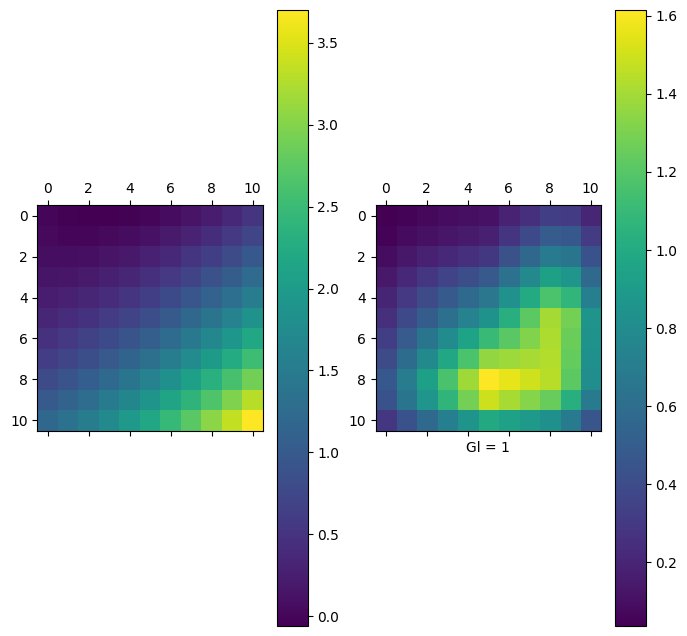

GL 1 MSE: 0.4052114389711524


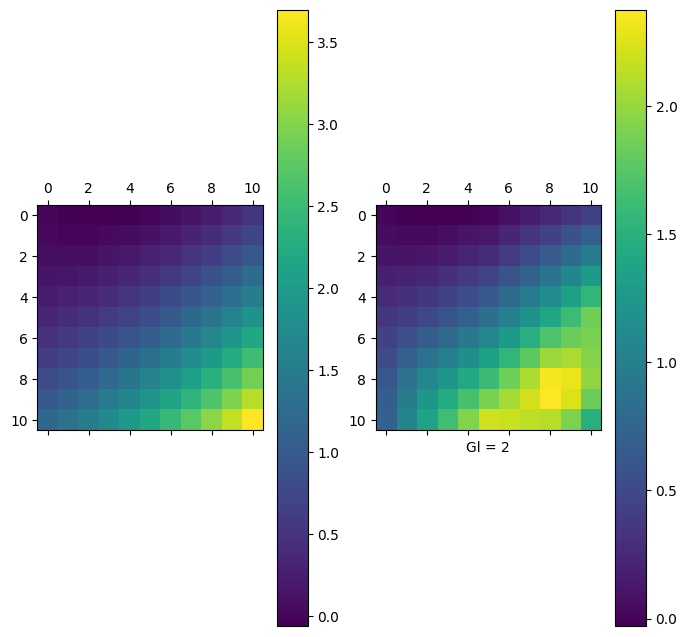

GL 2 MSE: 0.11685855202783745


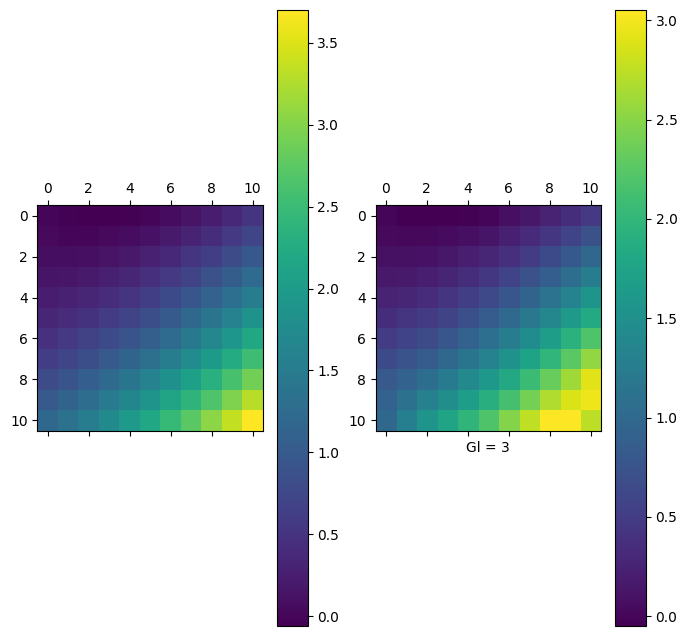

GL 3 MSE: 0.024257428898643043


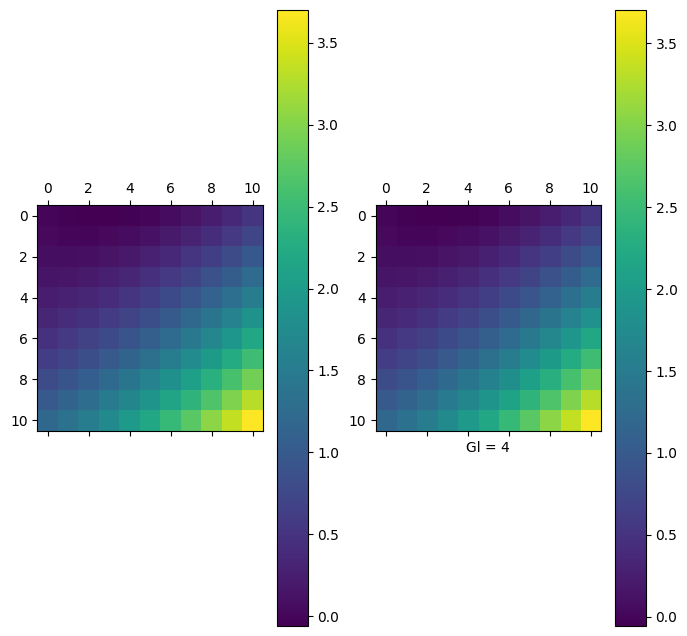

GL 4 MSE: 0.002249482701437988


In [9]:
## Testing interpolation for 2-D polynomial function 

ndim = 2
npoints = 160 + 1
func = lambda x:  -0.5*x[:, 0] + (x[:, 0] + x[:, 1])**2 + 0.2*x[:, 1]

ndimpoints = 11
epsilon = 10**(-7)
x1s = np.linspace(0 + epsilon, 1 - epsilon, num=ndimpoints)
x2s = np.linspace(0 + epsilon, 1 - epsilon, num=ndimpoints)
x1, x2 = np.meshgrid(x1s, x2s) # Generate grid
X = np.vstack([x1.ravel(), x2.ravel()]).T
npoints = X.shape[0]


for gl in range(0, 5):
    
    order = compute_LI(gl, ndim, rmat=False)
    sg_locs = get_sg_points_nd(gl, ndim, umin=-0.2, basis=SgBasisType.NAIVE, umax=1.2, ordered=False)
    sg_locs = sg_locs[order, :]
    f_sg = func(sg_locs)
    
    f_h = interpolate_nd(func, f_sg, X, gl, ndim, -0.2, 1.2)

    figsize=(8, 8)
    vmin=-10
    vmax=12
    fig, axs = plt.subplots(1, 2, figsize=figsize)    
    aax = axs[0].matshow(func(X).reshape(ndimpoints, ndimpoints)) #,vmin=-1, vmax=1)
    fig.colorbar(aax, ax=axs[0])
    aax = axs[1].matshow(f_h.reshape(ndimpoints, ndimpoints)) #, vmin=-1, vmax=1)
    fig.colorbar(aax, ax=axs[1])
    plt.xlabel('Gl = ' + str(gl))
    plt.show()
    print("GL", gl, "MSE:", np.mean(np.abs(func(X) - f_h)))